# Animations in Makie

Experimenting with `Makie` [animations](https://docs.makie.org/v0.18.0/documentation/animation/index.html) to see if it's viable.

So far, I haven't found a viable use case for this yet since the base `Plots` library in Julia is so good and the syntax there is more intuitive.

In [1]:
# using GLMakie
using CairoMakie
# Use a custom theme for fun
include("cyberpunk_theme.jl")
set_theme!(cyberpunk_theme)

From the docs:

> To create an animation you need to use the `record` function.

> * First you create a `Figure`
> * Next, you pass a function that modifies this figure frame-by-frame to record. Any changes you make to the figure or its plots will appear in the final animation. 
> * You also need to pass an iterable which has as many elements as you want frames in your animation. The function that you pass as the first argument is called with each element from this iterator over the course of the animation.

## A simple goal: Create a dot that moves up and to the right

Let's try to keep this example really, really simple: animate a dot that's moving up and to the right as time passes by. 

To do that, I think we have to understand two key concepts: `Observable`s and *listeners*.

* `Observable`: A variable that changes with each frame in your animation
* *listeners*: Functions of the `Observable`

### Observables

An `Observable` is something that `Makie` is designed to 'listen' to and react to changes. We declare an `Observable` like below:

In [2]:
time = Observable(0.0)

Observable(0.0)


The above code created an `Observable` called `time` that currently has the value of 0.0. We can update the current value of `time` by simply using this *empty* bracket notation:

In [3]:
time[] = 10
time

Observable(10.0)


### Create listeners:

Use the `@lift` macro to define a relationship with an `Observable`. 

In this example, both the `x` and `y` coordinates will depend only on `time`:

In [4]:
x = @lift(1 + $time)
y = @lift(5 + 0.5*($time))
# look at time
time

Observable(10.0)
    0 => map((::var"#1#2")(arg1) in Main)
    0 => map((::var"#3#4")(arg1) in Main)


If we look at `time` again, we should see that it has 2 listeners now.

After we've created our `Observable` and *listeners* `x` and `y`, we need to follow 3 steps to create our animation:

1. Create a figure: `fig`
2. Create an iterator that has the same number of elements as frames in the animation: `timestamps`
3. Create a function that changes the `Observable`: `move_dot`
    * Changes the value of `time`, which in turn, changes `x` and `y`

In [5]:
# 0. Create `Observable` and listeners `x` and `y`:
time = Observable(0.0)
time[] = 10 # initial value
x = @lift(1 + $time)       
y = @lift(5 + 0.5*($time))

# 1. Create a figure
fig = scatter(x, y, color = :red, markersize = 20,
    axis = (title = @lift("t = $(round($time, digits =1))"),))

# 2. Next, pass a function that modifies this figure frame by frame to record.
"""
Update the value of observable `time` to be equal to t, 
where t is from the timestamps iterator (i.e. a value between 0 and 5)
"""
function move_dot(t)
    time[] = t
end

# 3. pass an iterable that has the same number of elements as frames in the animation
framerate = 30
timestamps = range(0, 5, step=1/framerate)

# 4. Create an animation from the function
record(move_dot, fig, "moving_dot.gif", timestamps;
        framerate = framerate) 

# # Alternate with `do` notation to make an anonymous function:
# record(fig, "moving_dot.gif", timestamps;
#         framerate = framerate) do t
#     time[] = t
# end

"moving_dot.gif"

What this code does:
* for every `t` in the iterator `timestamps` (which is a `range` between 0 and 5)
* call the `move_dot` function with a single `t` as input
* each frame of animation will be based on each visualization after `move_dot` changes the `x` and `y` values

![img](moving_dot.gif)

What about using a `Point2f` type as the `Observable`? Instead of setting `x` and `y` as listeners that depend on `time`, we could instead change the type of `Observable` so that it's a 2d point.

In [6]:
# 0. Create a 2-d `Observable`/listener combo
location = Observable(Point2f(0,0))

# 1. Create a figure
fig, ax, scatterplot = scatter(location, color = :red, markersize = 20,
    axis = (title = @lift("t = $($location)"),))

# Pro tip: The scale of the axis doesn't update automatically as the dot moves,
# so manually set your limits!
limits!(ax, 0, 30, 0, 30)

# 2. Next, pass a function that modifies this figure frame by frame to record.
"""Update the point location at each frame"""
function move_dot2(i)
    location[] = location[] + [0.5, 0.75]
end

# 3. Pass an iterable that has the same number of elements as frames in the animation
framerate = 30
frames = 1:framerate

# 4. Create an animation with `record`
record(move_dot2, fig, "moving_dot2.gif", frames;
        framerate = framerate) 

"moving_dot2.gif"

![img](moving_dot2.gif)

## Line Plot Example

Next, we'll compare the output from base `Plots` to animate a line plot. Here's an example of the syntax for animating a line plot with `Plots`:

```julia
using Plots
# Simple dataset of 50 random numbers
y = rand(50)

# Use the @animate macro in front of a loop to create each frame of your animation
anim = @animate for i in 1:50
    # At each iteration we will plot a new subset of the data
    # I set the xlimits and ylimits so the x/y axes don't autofit as the data grows
    plot(y[1:i], 
         xlims=(1,50),
         ylims=(0,1))
end

# Save the animation as a gif and display it
gif(anim)
```

The above code should create a line plot where the lines grow from left to right.

Let's see how `Makie` compares:

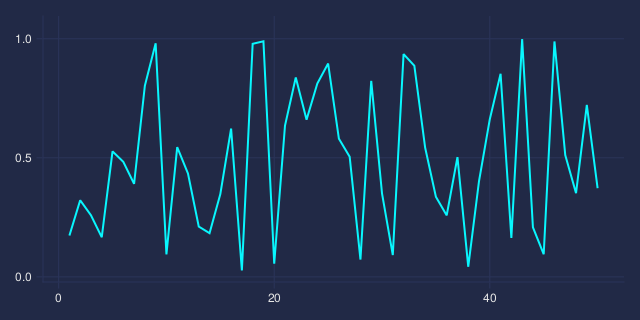

In [7]:
using Random
Random.seed!(42)

y = rand(50)
x = range(1,50)
fig = lines(x,y)

Next let's animate it using the `Point2f` syntax to hold our points. An `Observable` is an array so the value will start at (0,0) but we'll append new points to the array for each frame in the animation.

In [8]:
points = Observable(Point2f[(0, 0)])

fig, ax, lineplot = lines(points)
limits!(ax, 0, 50, 0, 1)

function update_lines(i)
    new_point = Point2f(x[i], y[i])
    # Observables are arrays, so you can add to them
    points[] = push!(points[], new_point)
end

record(update_lines, fig, "moving_lines.gif", 1:50; framerate=12)

"moving_lines.gif"

![img](moving_lines.gif)